<a href="https://colab.research.google.com/github/lhiwi/credit-risk-model/blob/task-3/notebooks/feature-engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Feature-engineering

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [14]:
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/Data_5/Data/data.csv'
df = pd.read_csv(data_path, parse_dates=['TransactionStartTime'])
print("Raw data shape:", df.shape)
df.head(3)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Raw data shape: (95662, 16)


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0


RFM-Transformer prototype

In [15]:
class RFMTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, snapshot_date=None):
        self.snapshot_date = snapshot_date

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df_ = X.copy()
        df_['TransactionStartTime'] = pd.to_datetime(df_['TransactionStartTime'])
        snapshot = self.snapshot_date or df_['TransactionStartTime'].max() + pd.Timedelta(days=1)
        rfm = (
            df_.groupby('CustomerId')
               .agg(
                   Recency=('TransactionStartTime', lambda ts: (snapshot - ts.max()).days),
                   Frequency=('TransactionId', 'count'),
                   Monetary=('Value', 'sum'),
               )
        )
        # Return only the numeric RFM columns
        return rfm.reset_index()[['CustomerId','Recency','Frequency','Monetary']]

# Test it
rfm_df = RFMTransformer().transform(df)
print("RFM sample:")
rfm_df.head()

RFM sample:


,CustomerId,Recency,Frequency,Monetary
0,CustomerId_1,84,1,10000
1,CustomerId_10,84,1,10000
2,CustomerId_1001,90,5,30400
3,CustomerId_1002,26,11,4775
4,CustomerId_1003,12,6,32000


In [16]:
# scale RFM features
# Build a numeric pipeline that scales only the numeric RFM columns
numeric_pipeline = Pipeline([
    ('scale', StandardScaler()),
])

# Extract numeric part and scale
rfm_values = rfm_df[['Recency','Frequency','Monetary']]
rfm_scaled = numeric_pipeline.fit_transform(rfm_values)

# Reassemble into DataFrame
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency','Frequency','Monetary'])
rfm_scaled_df['CustomerId'] = rfm_df['CustomerId'].values

print("Scaled RFM head:")
rfm_scaled_df.head()


Scaled RFM head:


,Recency,Frequency,Monetary,CustomerId
0,1.937605,-0.253459,-0.089524,CustomerId_1
1,1.937605,-0.253459,-0.089524,CustomerId_10
2,2.158882,-0.212186,-0.082011,CustomerId_1001
3,-0.201408,-0.150278,-0.091448,CustomerId_1002
4,-0.717722,-0.201868,-0.081422,CustomerId_1003


Temporal-transformer

In [17]:
class TemporalAggregator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        df_ = X.copy()
        df_['hour'] = pd.to_datetime(df_['TransactionStartTime']).dt.hour
        df_['day']  = pd.to_datetime(df_['TransactionStartTime']).dt.day
        df_['month']= pd.to_datetime(df_['TransactionStartTime']).dt.month
        # Aggregate per customer
        agg = df_.groupby('CustomerId').agg({
            'hour': 'mean',
            'day': 'mean',
            'month': 'mean'
        }).reset_index()
        return agg

# Test it
temp_df = TemporalAggregator().transform(df)
print("Temporal sample:")
temp_df.head()


Temporal sample:


,CustomerId,hour,day,month
0,CustomerId_1,16.000000,21.000000,11.000000
1,CustomerId_10,16.000000,21.000000,11.000000
2,CustomerId_1001,7.800000,16.000000,11.000000
3,CustomerId_1002,13.454545,14.727273,8.636364
4,CustomerId_1003,14.333333,1.000000,2.000000


categorical-encoding

In [20]:
class CategoricalAggregator(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df_ = X.copy()
        # One-hot encode the entire transaction-level DataFrame,
        # then aggregate per customer by summing the binaries.
        onehot = pd.get_dummies(df_[self.cols].astype(str), prefix=self.cols)
        onehot['CustomerId'] = df_['CustomerId']
        agg = onehot.groupby('CustomerId').sum().reset_index()
        return agg

# Test it
cat_cols = ['ProductCategory','ChannelId','PricingStrategy']
cat_df = CategoricalAggregator(cat_cols).transform(df)
print("Categorical aggregation sample:")
cat_df.head(3)


Categorical aggregation sample:


,CustomerId,ProductCategory_airtime,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill,ChannelId_ChannelId_1,ChannelId_ChannelId_2,ChannelId_ChannelId_3,ChannelId_ChannelId_5,PricingStrategy_0,PricingStrategy_1,PricingStrategy_2,PricingStrategy_4
0,CustomerId_1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,CustomerId_10,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,CustomerId_1001,2,0,3,0,0,0,0,0,0,0,2,3,0,0,0,5,0


combining feature

In [21]:
# Merge RFM, temporal, and categorical on CustomerId
merged = (
    rfm_scaled_df
    .merge(temp_df, on='CustomerId', how='left')
    .merge(cat_df, on='CustomerId', how='left')
)
print("Merged feature DataFrame shape:", merged.shape)
merged.head(3)

# Save for inspection
merged.to_csv('/content/drive/MyDrive/Data_5/Data/features_debug.csv', index=False)


Merged feature DataFrame shape: (3742, 24)


visualization

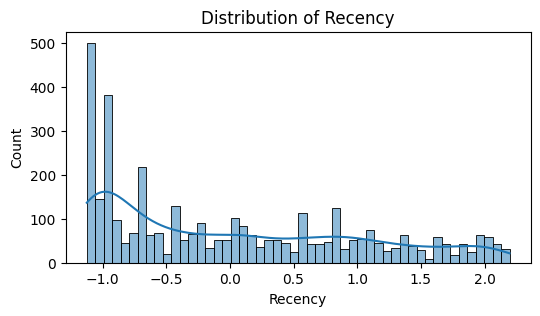

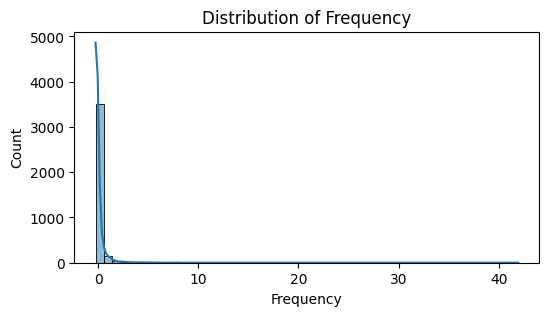

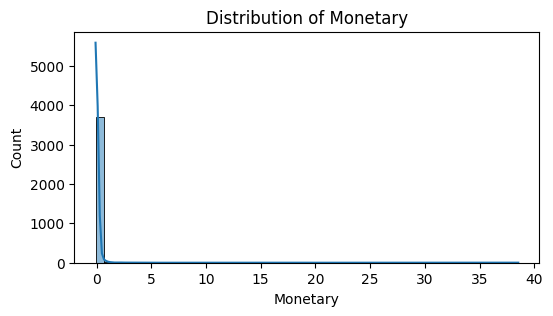

In [23]:
# Histograms for RFM features
for col in ['Recency','Frequency','Monetary']:
    plt.figure(figsize=(6,3))
    sns.histplot(merged[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()



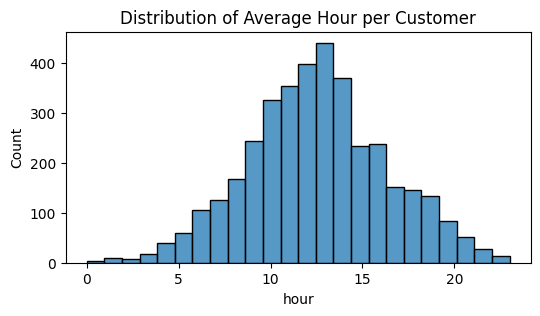

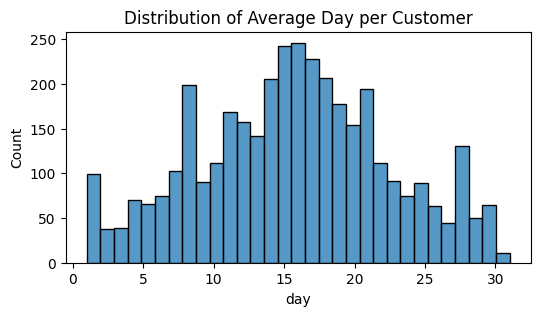

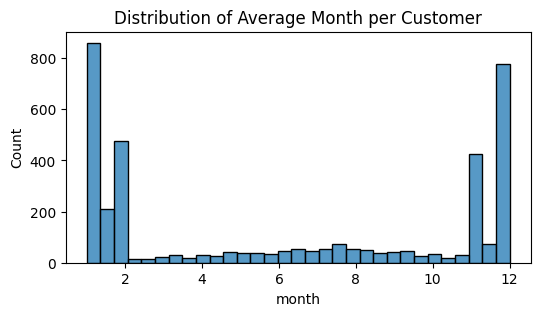

In [24]:
# Temporal feature distributions
for col in ['hour','day','month']:
    plt.figure(figsize=(6,3))
    sns.histplot(merged[col], bins=24 if col=='hour' else 31, kde=False)
    plt.title(f'Distribution of Average {col.capitalize()} per Customer')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()


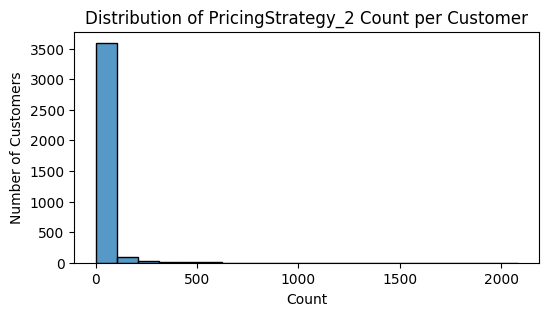

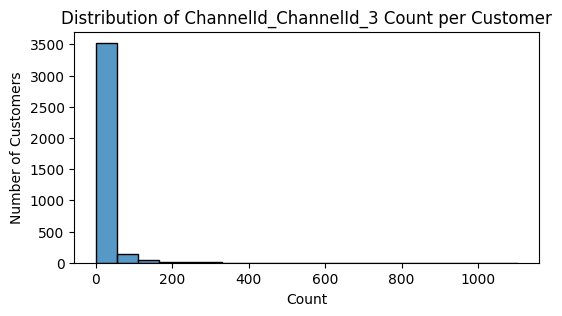

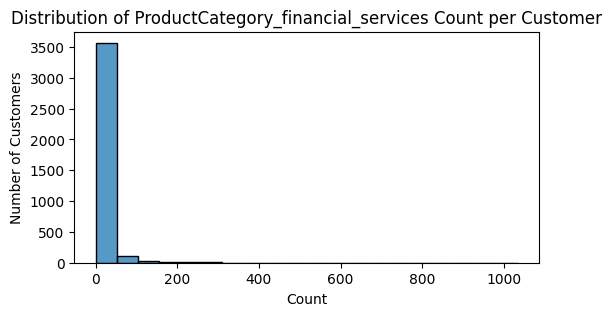

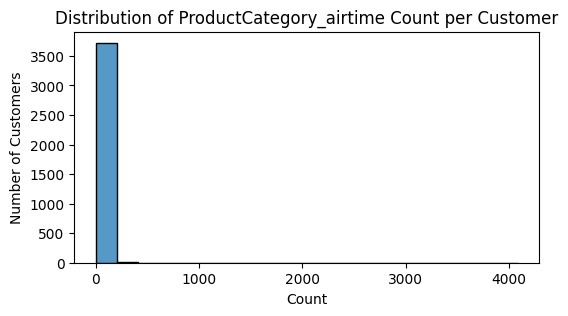

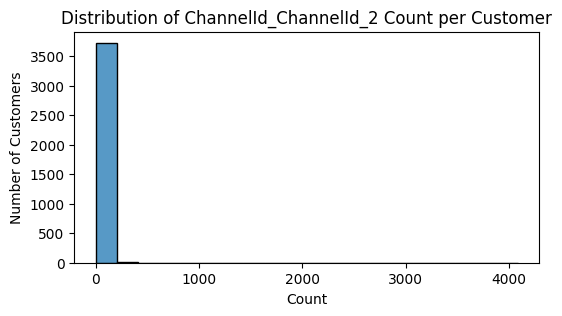

In [25]:
#  Bar plots for a sample of categorical count features
#    (e.g., top 5 most frequent one-hot columns)
cat_feature_cols = [c for c in merged.columns if c not in
                    ['CustomerId','Recency','Frequency','Monetary','hour','day','month']]
# pick top 5 columns by overall sum
top5 = merged[cat_feature_cols].sum().sort_values(ascending=False).head(5).index.tolist()

for col in top5:
    plt.figure(figsize=(6,3))
    sns.histplot(merged[col], bins=20)
    plt.title(f'Distribution of {col} Count per Customer')
    plt.xlabel('Count')
    plt.ylabel('Number of Customers')
    plt.show()